# MODELLING SLOW EXTRACTION INDUCED RADIOACTIVITY IN SPS LSS2 USING MCMC HAMMER

<p style="font-family:Century Gothic;"> Resonant slow extraction is used to deliver an intense flux of protons at 400 GeV to Fixed Target Experiments in the North Area (NA) at the Super Proton Synchrotron (SPS) in CERN. The resonantly excited beam is deflected using 5 electrostatic wire septa (ZS), that are placed in the slow extraction region, Long Straight Section 2 (LSS2). During extraction, beam loss is induced by the small fraction of the beam that impacts the wires of the ZS septum activating the equipment. To measure the prompt loss during extraction Beam Loss Monitors (BLM) are used. In addition, a series of ionization chambers (PMIUs) are used to measure the induced radioactivity (IR) during cool-down periods. </p>


<img src="LSST.png">
[LSS2 slow extraction region](files/LSST.png)

### Empirical model of Induced Radioactivity (IR)

<p style="font-family:Century Gothic;">An empirical model has been developed to predict the evolution of the induced radioactivity at the ionization chambers (PMIUs). After irradiation, the exponential decay of the IR can be expressed as:</p>
$IR(t) \; \alpha \; \exp(\frac{-t}{\tau(t)})$

<p style="font-family:Century Gothic;">The most suitable model at the SPS was shown to be:</p>

$\tau(t) = \frac{t}{k_1 ln(t)^{k_2}}$
<p style="font-family:Century Gothic;">The measured extracted proton flux P_ex and the prompt normalized loss per proton N_L were introduced to the model in order to consider the extraction efficiency. The model was discretized in time using bins of Δt = 30 minutes, therefore, an exponential decay function is generated every bin. The $n^{th}$ bin is the sum of exponential decays from the previous bins, as described by following equation:</p>

$IR_{n}= G\;\sum_{i=1}^{n} N_{L,\,n+1-i}P_{ex,\, n+1-i}\exp\left( -k_{1}\ln\left( t\right) ^{k_{2}}\right)$

<p style="font-family:Century Gothic;">**$G$** is a constant conversion factor that depends on the primary beam energy, material composition and geometry of the machine, considering the relative position of the detectors and their calibrations, while **$k_1$** and **$k_2$** are decay constants. </p>

### Python code to load BLM measured data

<p style="font-family:Century Gothic;">In the next python code: the BLM measured data, that corresponds to the measured extracted proton flux normalized by the loss per proton, is obtained from a data base comming from the ZS2. Also, the $IR$ model is defined as a function called **decay**.</p>


<p style="font-family:Century Gothic;">The constants **$k_1$** and **$k_2$** and $G$ for 2016 were determined empirically by a nonlinear fitting routine on logged measurement data from the PMIU.</p>


In [1]:
"""
Original code to get ZS data created by Philipp Schicho.
Modified by Aurora C. Araujo 

"""

import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
%matplotlib inline

import numpy as np
import pandas as pd
import pytimber
from pytimber import pagestore

import csv
import re
import glob, os

import multiprocessing as mp
from functools import partial


from scipy.optimize import curve_fit, minimize

# -----------------------------------------------------------------------
# Plot model for given year, ZS and predetermined Fit parameters k1, k2, k3 (G)
# -----------------------------------------------------------------------

# Getting measured data from db file to plot the model

# Defining a vectorized function for time
TimestampToDate = np.vectorize(dt.datetime.fromtimestamp)

# Definition to change the time from db file into this format.
def StrToTimestamp(ts):
  return time.mktime(time.strptime(ts,"%Y-%m-%d %H:%M:%S.%f"))

# Selected year to get the data
year = 2016

# Choosing initial and final time to get data
t1 = str(year)+'-05-01 00:00:00.000'
t2 = str(year)+'-06-01 00:00:00.000'
m1 = dt.datetime.strptime(t1,"%Y-%m-%d %H:%M:%S.%f").month
m2 = dt.datetime.strptime(t2,"%Y-%m-%d %H:%M:%S.%f").month

# set length of bin with \Delta t
T ='H' # Measured data each hour


# Defining the data base from where we are going to get the data 
db = pagestore.PageStore('data_'+str(year)+'.db','./data_'+str(year))
dev = ["SPS.BLM.21652.ZS2:LOSS_CYCLE"]
print dev

all_dat = {}
for d in dev:
  if d not in db.search():
    print str(d)+' database not found need to load data'

  # Getting data from data base  
  dat =  db.get(d,StrToTimestamp(t1),StrToTimestamp(t2))
  date, data = dat[d] 
  
  # Formatting data
  date = TimestampToDate(date)
    
  # Filtering saturated data
  b = data < 1e-2
  data[b] = 0

  series = pd.Series(data, index=date)
  
  # Arranging array of data for each hour
  if d == dev[0]:
    series = series.resample(T).sum()
    
  # Putting all data and dates into one array
  date = series.index.to_pydatetime()
  data = np.nan_to_num(series.values)
  all_dat[d] = [date, data]


#-----------------------------------------------------------------------
# Model to fit data of relevant decay points
#-----------------------------------------------------------------------

def decay(n, P, k):
  s0 = 0.581328004
  if np.isscalar(n):
      n = (n,)

  ext = np.exp(-k[0]*np.log(range(n[-1]))**k[1])
  res = []
  for nn in n:
    Pt = P[:nn] # 0...n
    b = Pt > 0
    delt = nn - np.where(b)[0]

    Pt = Pt[b]
    ex = ext[delt]
    res.append(sum(Pt * ex))

  return (np.array(res) + s0)*k[2]


# -----------------------------------------------------------------------
# Decay constants for 2016 ZS2 over extraction region
# -----------------------------------------------------------------------
k1 = 3.01141748e+00
k2 = 6.93995598e-01
k3 = 1.73958156e-03 # This constant corresponds to G

p_opt = [k1,k2,k3]

print 'Best values for 2016 [k1,k2,k3] =',(p_opt)


['SPS.BLM.21652.ZS2:LOSS_CYCLE']
Best values for 2016 [k1,k2,k3] = [3.01141748, 0.693995598, 0.00173958156]


## Calculating IR constants using MCMC hammer method

### Generating measured data
<p style="font-family:Century Gothic;">We will apply the MCMC hammer method to determine the constants of the $IR$ model for 2016 data. Since we do not have the measured PMIU data that was used to determined the optimal constants (p_opt) for $IR$ of 2016, we will use these constants in the decay function to generate our data. In order to simulate real data, we will add a random error to the decay values of I, and we will use these random errors as our standar deviation.</p>

<p style="font-family:Century Gothic;"></p>



In [21]:
#-----------------------------------------------------------------------
# Generating values that will be our measured decay data
#-----------------------------------------------------------------------

P = all_dat[dev[0]][1] # ZS2 BLM measured data for the decay funcion
t = range(len(all_dat[dev[0]][0])) # Setting an array for time given dates from ZS2 BLM data
I = decay(t, P, p_opt) # Generating a decay function with p_opt parameters for 2016

# Here we create an error bar data_x and values for the measured decay data_raw
data_x = [] 
data_raw = []
for i in range(len(I)):
    I_n = I[i]/10*np.random.random() # Creating random error from the I values
    data_x.append(I_n)
    real = np.random.randint(-1,2)*I_n + I[i]
    data_raw.append(real)
data_x = np.array(data_x) # Array for error values
data_raw = np.array(data_raw)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log


### Running MCMC hammer using emcee and corner
<p style="font-family:Century Gothic;">The next step is to apply the MCMC hammer method, for this we will define the logarithm of likehood, prior, and probability. Then we get the best values for the constants of the model, and finally we run the MCMC hammer using the library emcee for 20 walkers that make 2000 steps each.</p>

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in power


Best k1:  3.0120322975  Best k2:  0.693880309159  Best k3:  0.00173982899952


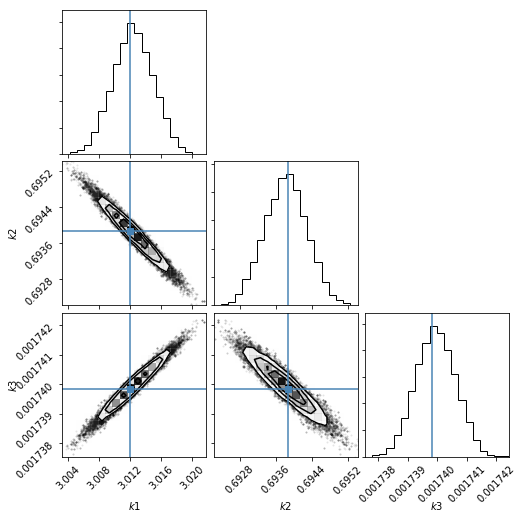

In [3]:
#-------------------------------------------------------------------------------
# Applying MCMC hammer method to get the best values for the parameters k1,k2,k3
#-------------------------------------------------------------------------------

import scipy.optimize as op
import emcee
import corner

# Defining loglikehood
def lnlikehood(p_opt,y,t,P,sigmay):
    y_d = y - decay(t, P, p_opt)
    lk = (y_d)**2/sigmay**2
    lk = -0.5*np.sum(lk)
    return lk 



# Defining prior for p_opt
def lnprior(p_opt):
    if ((k1+2*k1)>p_opt[0]>(k1-2*k1) and (k2+2*k2)>p_opt[1]>(k2-2*k2) and (k3+2*k3)>p_opt[2]>(k3-2*k3) ): 
        return 0.0
    else:
        return -np.infty
    return 


# Defining logprobability 
def lnprob(p_opt,I,t,P,sigmay):
    lp = lnprior(p_opt)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikehood(p_opt,I,t,P,sigmay)


# Initial values for parameter of the decay model
k1 = 2.0e+00
k2 = 7.0e-01
k3 = 1.0e-03

# Array for the parameters
p_true = [k1,k2,k3]

# Defining the standard deviation of the measured decay data
sigmay = data_x

# Getting the best values por the parameter given that maximize the likehood for measured decay data
nll = lambda *args: -lnlikehood(*args)
result = op.minimize(nll, p_true, args = (data_raw,t,P,sigmay))
k1_b, k2_b, k3_b = result["x"]
print 'Best k1: ',k1_b,' Best k2: ',k2_b,' Best k3: ',k3_b

# Setting ndim as number of parametor to fit and nwalkers as number of walkers for MCMC
ndim, nwalkers = 3, 20

# Setting the initial parameter values for each walker
pos = [result["x"] + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]

# Running the walkers for nsteps 
nsteps = 2000
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data_raw,t,P,sigmay))
sampler.run_mcmc(pos, nsteps)

# Taking out some burning
samples = sampler.chain[:,300:,:].reshape((-1, ndim))

# Plotting triangle histograms
fig = corner.corner(samples, labels=["$k1$", "$k2$","$k3$"],
                      truths=[k1_b, k2_b,k3_b])


### Sampling for k1, k2, k3

<p style="font-family:Century Gothic;">In this section we plot the sampling of the decay model's constants for each walker.</p>




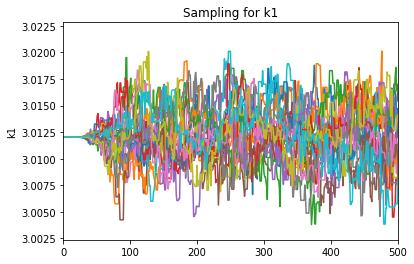

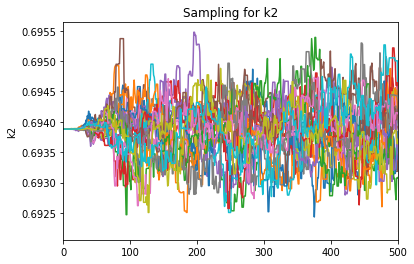

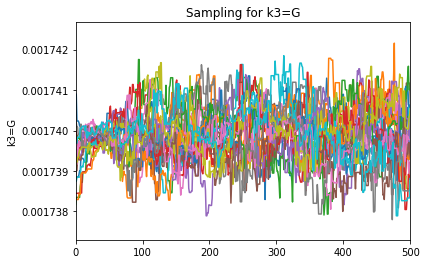

In [14]:
#-------------------------------------------------------------------------------
# Plotting walkers sampling for chains of k1,k2,k3
#-------------------------------------------------------------------------------

# Plot sampling for k1
for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,0])
plt.ylabel('k1')
plt.title('Sampling for k1')
plt.xlim(0,500)
plt.show()


# Plot sampling for k2
for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,1])
plt.ylabel('k2')
plt.title('Sampling for k2')
plt.xlim(0,500)
plt.show()

# Plot sampling for k3
for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,2])
plt.ylabel('k3=G')
plt.title('Sampling for k3=G')
plt.xlim(0,500)
plt.show()

### Comparing results 

<p style="font-family:Century Gothic;">In the next section we compared the generated measured decay data with the fitting model using the already known optimal constants from 2016, and the constants that we have calculated here using MCMC hammer method.</p>



/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log


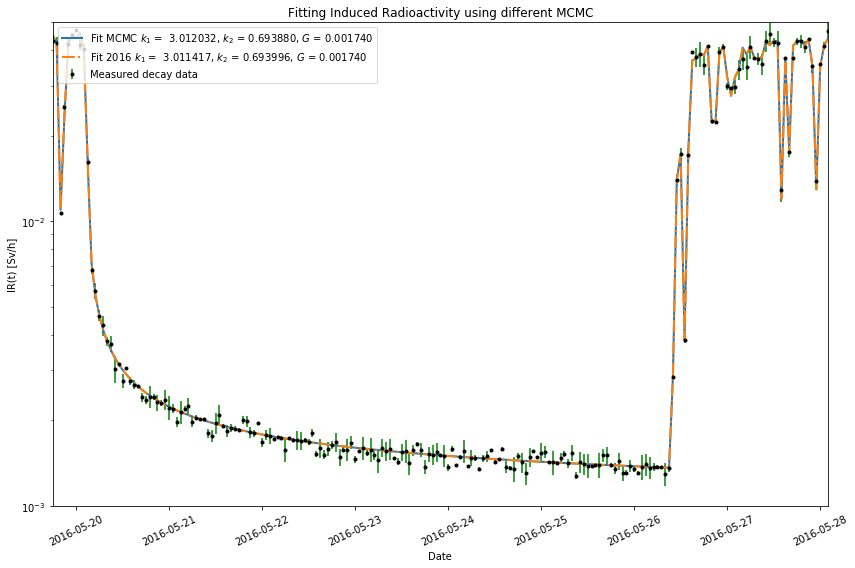

In [22]:
#-------------------------------------------------------------------------------
# Plotting the 'measured decay data' and the fit with the best values
#-------------------------------------------------------------------------------

# Getting decay data for the best fit obtained using MCMC hammer
I_fit = decay(t,P,result['x'])

plt.figure(figsize=(12,8))
# Plot for generated 'measured decay data'
plt.errorbar(all_dat[dev[0]][0],data_raw,yerr=sigmay,fmt='.k',ecolor='g',label = 'Measured decay data')
# Plot for decay data for the best fit using MCMC hammer
plt.semilogy(all_dat[dev[0]][0], I_fit,label = r"Fit MCMC $k_1$ =  %.6f" %result['x'][0] +r", $k_2$ = %.6f" %result['x'][1] +r", $G$ = %.6f" %result['x'][2],linewidth=2)
# Plot for decay data for the optimal fit of 2016
plt.semilogy(all_dat[dev[0]][0], I,'-.', label = r"Fit 2016 $k_1$ =  %.6f" %p_opt[0] +r", $k_2$ = %.6f" %p_opt[1] +r", $G$ = %.6f" %p_opt[2],linewidth=2)

# Plot Range
plt.xlim(all_dat[dev[0]][0][450],all_dat[dev[0]][0][650])
plt.ylim(1e-3,5e-2)
plt.title('Fitting Induced Radioactivity using different MCMC')
plt.xticks( rotation=25 )
plt.xlabel('Date')
plt.ylabel('IR(t) [Sv/h]')
lgd1=plt.legend(loc="upper left",prop={'size':10}, frameon=None)
plt.tight_layout()
plt.show()

#

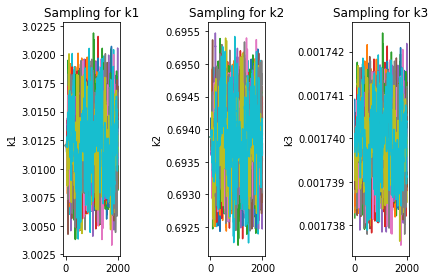

In [37]:
f, axarr = plt.subplots(nrows=1, ncols=3)

for i in range(nwalkers):
    axarr[0].plot(sampler.chain[i,:,0])
axarr[0].set_title('Sampling for k1')
axarr[0].set_ylabel('k1')
for i in range(nwalkers):
    axarr[1].plot(sampler.chain[i,:,1])
axarr[1].set_title('Sampling for k2')
axarr[1].set_ylabel('k2')
for i in range(nwalkers):
    axarr[2].plot(sampler.chain[i,:,2])
axarr[2].set_title('Sampling for k3')
axarr[2].set_ylabel('k3')
# Fine-tune figure; make subplots farther from each other.
#f.subplots_adjust(left=None, bottom=None, right=None, top=None,
                #wspace=1.1, hspace=None)

    
f.tight_layout() # Or equivalently,  "plt.tight_layout()" asegura q se separen horizontalmente